In [1]:
from plotting import *

# before and after fine-tuning
import seaborn as sns
sns.set(style='whitegrid', font_scale=1.8)

100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


Exp hierarchical:False | np-gating:True, best ret 0.9405+-0.0139, avg ret 0.9032+-0.0149; max ret 0.9046+-0.0145
Exp hierarchical:False | np-gating:False, best ret 0.9103+-0.0087, avg ret 0.7930+-0.0321; max ret 0.7932+-0.0323
Exp hierarchical:True | np-gating:True, best ret 0.9498+-0.0099, avg ret 0.9123+-0.0166; max ret 0.9138+-0.0173
Exp hierarchical:True | np-gating:False, best ret 0.9155+-0.0114, avg ret 0.7889+-0.0302; max ret 0.7892+-0.0302


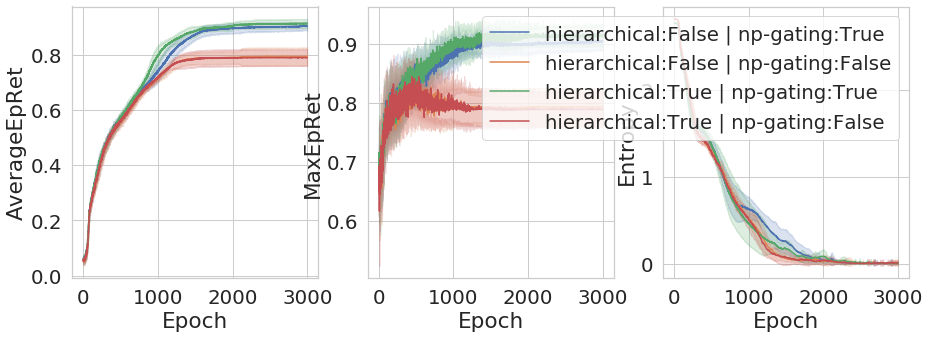

In [12]:
hparams = ['ac_kwargs_hierarchical', 'ac_kwargs_not_repeat']
abbrs = ['hierarchical', 'np-gating']
folder = '/home/hzwang/Experiments/0321_perfect_absorber6'
df = compare_across_hparams(folder, hparams, abbrs)

In [13]:
def avg_max_plot(df, hparams, abbrs):
    
    unique_hvals = []
    for h in hparams:
        unique_hvals.append(list(df[h].unique()))
        
    hparam_combs = list(product(*unique_hvals))
    legends = [' | '.join([abbr+':'+str(h) for abbr, h in zip(abbrs, item)]) for item in hparam_combs]
    fig, ax = plt.subplots(1,2, figsize=(14, 5))
    
    vals = [[True, True], [True, False], [False, True], [False, False]]
    
    for i, hvals in enumerate(vals):
        df_ = select_subset(df, hparams, hvals)
        sns.lineplot(x='Epoch', y='AverageEpRet', ci='sd', hue=None, data=df_, ax=ax[0])
        sns.lineplot(x='Epoch', y='MaxEpRet', ci='sd', hue=None, data=df_, ax=ax[1])
        ax[0].set_ylim([0,1])
        ax[1].set_ylim([0.5,1])
        ax[0].set_xlim([0,3000])
        ax[1].set_xlim([0,3000])
        ax[0].set_ylabel('Average absorption')
        ax[1].set_ylabel('Max absorption')
        
        grouped_df = df_.groupby('Epoch')
        avg_mean, avg_std = grouped_df['AverageEpRet'].mean()[-10:].mean(), grouped_df['AverageEpRet'].std()[-10:].mean() # average of avgret over the last 10 epochs
        max_mean, max_std = grouped_df['MaxEpRet'].mean()[-10:].mean(), grouped_df['MaxEpRet'].std()[-10:].mean() # average of the maxret over the last 10 epochs
        best_mean, best_std = df_.groupby('seed')['MaxEpRet'].max().mean(), df_.groupby('seed')['MaxEpRet'].max().std()
        # print mean and std of average EpRet and MaxEpRet
        print('Exp {}, best ret {:.4f}+-{:.4f}, avg ret {:.4f}+-{:.4f}; max ret {:.4f}+-{:.4f}'.format(legends[i], best_mean, best_std, avg_mean, avg_std, max_mean, max_std))
        
#     ax[0].set_rasterized(True)
#     ax[1].set_rasterized(True)
    plt.legend(['OML-PPO', 'Only gating', 'Only auto-regressive', 'None'])
    plt.savefig('./figures/traj.pdf', bbox_inches='tight')
    plt.show()
    
    return df

Initial reward 0.9603365151116536
[0.96, 0.955, 0.938, 0.955, 0.953, 0.941, 0.968, 0.947, 0.939, 0.942] 0.9709989355960247
Initial reward 0.9547215212161091
[0.96, 0.955, 0.938, 0.955, 0.953, 0.941, 0.968, 0.947, 0.939, 0.942] 0.9678618108053638
Initial reward 0.9381380159586764
[0.96, 0.955, 0.938, 0.955, 0.953, 0.941, 0.968, 0.947, 0.939, 0.942] 0.940217679578836
Initial reward 0.9545809557046631
[0.96, 0.955, 0.938, 0.955, 0.953, 0.941, 0.968, 0.947, 0.939, 0.942] 0.9742770197345759
Initial reward 0.9533610959058042
[0.96, 0.955, 0.938, 0.955, 0.953, 0.941, 0.968, 0.947, 0.939, 0.942] 0.9600894330340923
Initial reward 0.9406320459124833
[0.96, 0.955, 0.938, 0.955, 0.953, 0.941, 0.968, 0.947, 0.939, 0.942] 0.9764597282236401
Initial reward 0.9676587201718614
[0.96, 0.955, 0.938, 0.955, 0.953, 0.941, 0.968, 0.947, 0.939, 0.942] 0.9731150060465971
Initial reward 0.9467993538390103
[0.96, 0.955, 0.938, 0.955, 0.953, 0.941, 0.968, 0.947, 0.939, 0.942] 0.9569005621466565
Initial reward 0.

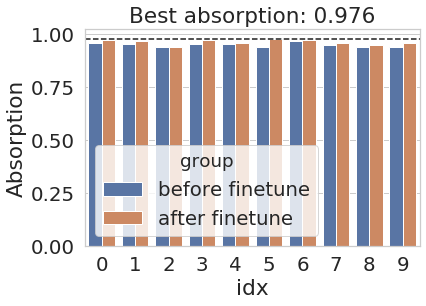

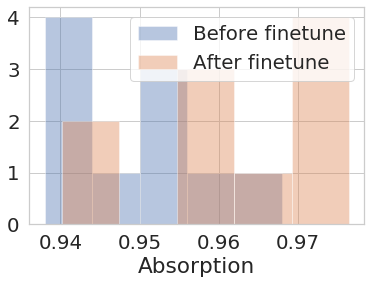

In [19]:
df_ = select_subset(df, hparams, [True, True])
m0s, x0s, merits = extract_designs(np.unique(df_['best_design'].to_numpy()).tolist())

env = get_env_fn('PerfectAbsorberVisNIR-v0', **{'discrete_thick': True,
                              'spectrum_repr': False,
                              "bottom_up": False, 'merit_func':cal_reward})()
x_opts, merits_opts = batch_finetune(df_, env, max_thick=200)

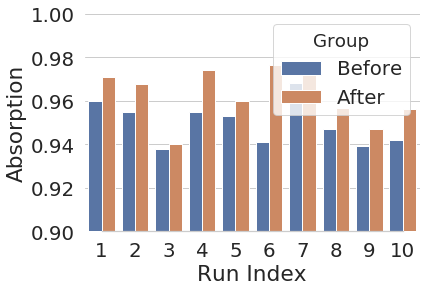

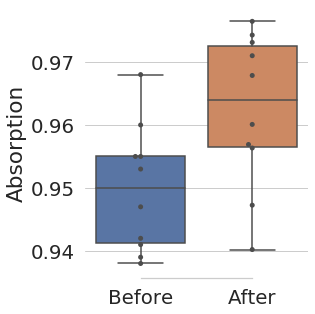

In [20]:
fig, ax = plt.subplots()
finetune_res = pd.DataFrame({'Absorption':merits+merits_opts, 'Group':['Before']*len(merits) + ['After']*len(merits), 'Run Index':list(range(1, len(merits)+1)) * 2})
sns.barplot(x='Run Index', y='Absorption', data=finetune_res, hue='Group')
plt.ylim([0.9, 1.0])
ax.yaxis.grid(True)
sns.despine(trim=True, left=True)
plt.savefig('./figures/finetune.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(4,5))
sns.boxplot(x='Group', y='Absorption', data=finetune_res)
sns.swarmplot(y='Absorption', x='Group', data=finetune_res, color='.3')
ax.yaxis.grid(True)
ax.set(xlabel="")
sns.despine(trim=True, left=True)
plt.savefig('./figures/distribution.eps', bbox_inches='tight')

In [17]:
best_idx = np.argsort(merits_opts)
m0s, x_opts, merits_opts = np.array(m0s), np.array(x_opts), np.array(merits_opts)
print(m0s[best_idx], x_opts[best_idx], merits_opts[best_idx])

m_best = m0s[best_idx]
x_best = x_opts[best_idx]

[list(['MgF2', 'Fe2O3', 'Ge', 'Cr'])
 list(['SiO2', 'ZnSe', 'Ti', 'ZnSe', 'Ti'])
 list(['SiO2', 'ZnSe', 'Ti', 'ZnS', 'Ti'])
 list(['SiO2', 'ZnSe', 'Ti', 'TiO2', 'Ti'])
 list(['MgF2', 'Fe2O3', 'Ti', 'HfO2', 'Ti'])
 list(['Al2O3', 'Fe2O3', 'Ti', 'Al2O3', 'Ti'])
 list(['Al2O3', 'Fe2O3', 'Ti', 'MgF2', 'Ti'])
 list(['SiO2', 'Fe2O3', 'Ti', 'Al2O3', 'Ti'])
 list(['MgF2', 'Fe2O3', 'Ti', 'MgF2', 'Ti'])
 list(['SiO2', 'Fe2O3', 'Ti', 'MgF2', 'Ti'])] [list([112, 68, 37, 195]) list([127, 64, 15, 57, 200])
 list([124, 59, 15, 67, 160]) list([124, 58, 15, 69, 156])
 list([125, 79, 15, 82, 200]) list([101, 70, 15, 109, 149])
 list([103, 69, 15, 125, 147]) list([114, 71, 15, 108, 154])
 list([127, 74, 15, 124, 169]) list([115, 70, 15, 124, 200])] [0.94021768 0.94726183 0.95634204 0.95690056 0.96008943 0.96786181
 0.97099894 0.97311501 0.97427702 0.97645973]


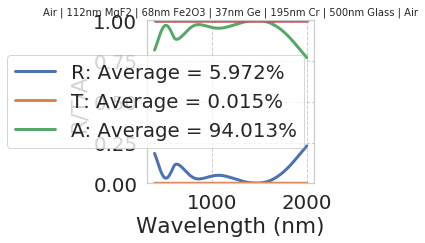

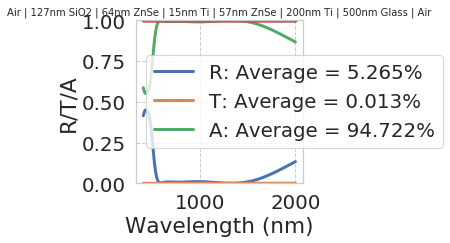

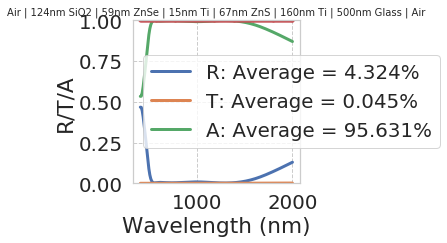

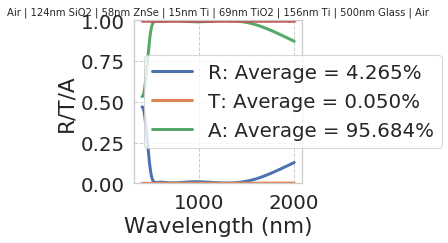

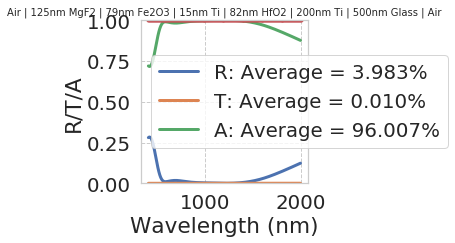

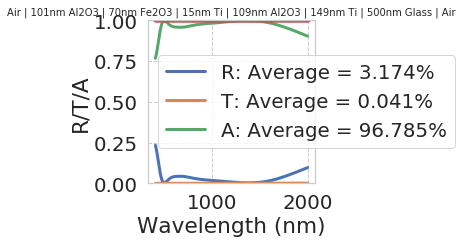

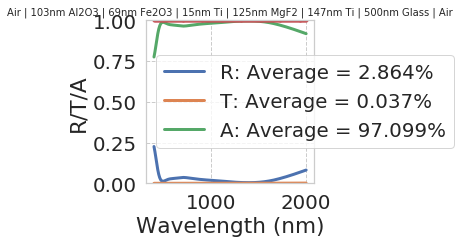

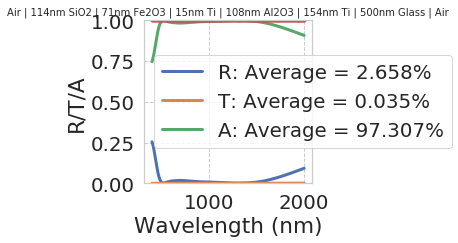

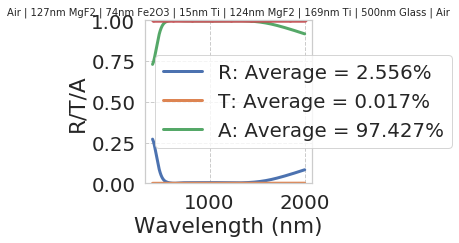

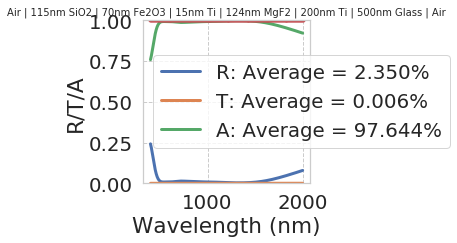

In [8]:
for i in range(len(best_idx)):
    m, x = list(m_best[i]), list(x_best[i])
    fig, ax = plt.subplots(figsize=(3,3))
    wavelengths = np.arange(0.4, 2.0+1e-3, 0.01)
    # wavelengths = env.simulator.wavelength
    simulator = TMM_sim(m, wavelengths, substrate='Glass', substrate_thick=500)
    
    R, T, A = simulator.spectrum(m, [np.inf]+x+[np.inf], theta=0, plot=True, title=True)
    plt.plot(env.simulator.wavelength*1e3, np.ones_like(env.simulator.wavelength), '.')
    # plt.legend(['Target absorption', 'Average absorption: {:.2f}%'.format(A.mean())])
    # plt.savefig('./figures/spectrum_maxlen6.eps', bbox_inches='tight')
    plt.show()

## angle-dependent absorption map

In [8]:
m = ['SiO2', 'Fe2O3', 'Ti', 'MgF2', 'Ti']
x = [115, 70, 15, 124, 200]

import seaborn as sns
sns.set(style='whitegrid', font_scale=1.8)
font = {'size':24}
matplotlib.rc('font', **font)
matplotlib.rc('axes', titlesize=16)

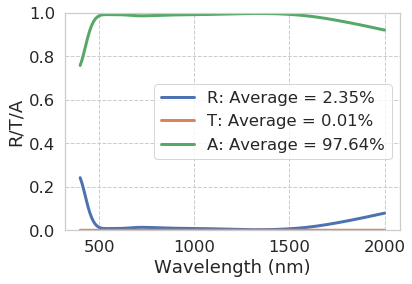

In [10]:
Rs = []
As = []
Ts = []

wavelengths = np.arange(0.4, 2.0+1e-3, 0.01)
angles = np.arange(0, 70.5, 0.5)
simulator = TMM_sim(m, wavelengths, substrate='Glass', substrate_thick=500)

sns.set(style='whitegrid', font_scale=1.5)
m, x = list(m), list(x)
_ = simulator.spectrum(m, [np.inf]+x+[np.inf], theta=0, plot=True)

plt.savefig('./figures/spectrum_maxlen6.pdf', bbox_inches='tight')
plt.show()

In [11]:
for d in tqdm(angles):
    R, T, A = simulator.spectrum(m, [np.inf]+x+[np.inf], theta=d)
    Rs.append(R)
    As.append(A)
    Ts.append(T)

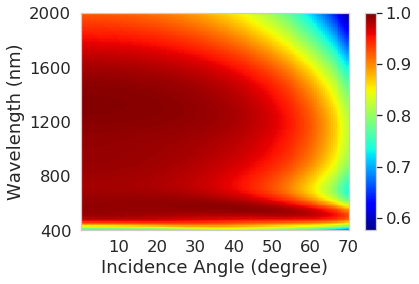

In [12]:
Rs, As, Ts = np.array(Rs), np.array(As), np.array(Ts)

fig, ax = plt.subplots()
yy, xx  = np.meshgrid(wavelengths*1000, angles)
c = ax.pcolormesh(xx, yy, As[:len(yy)], cmap='jet', vmin=np.min(As), vmax=1)

fig.colorbar(c, ax=ax)
plt.ylabel('Wavelength (nm)')
plt.xlabel('Incidence Angle (degree)')
# plt.title('Absorption')
ax.set_xticks(np.arange(10, 70.5, 10))
ax.set_yticks(np.arange(400, 2001, 400))
plt.savefig('./figures/angle_spectrum_maxlen6.eps', bbox_inches='tight')
# plt.savefig('./figures/angle_spectrum_maxlen14.eps', bbox_inches='tight')
plt.show()